## CV Assignment - 2
## Submitted By: Muhammad Jawad Bashir
## Registration No: 330295


### 1. Mounting Drive

In [ ]:
# For loading gdrive on colab
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Mounted at /content/gdrive
Google Drive is mounted



### 2. Imports

In [ ]:
# import the necessary packages
import tensorflow as tf  # for model related tasks
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For loading datasets
from tensorflow.keras.applications import EfficientNetB3, resnet50  # pretrained models from keras
from tensorflow.keras import layers  # for building architectures
from tensorflow.keras import models  # for building architectures
from tensorflow.keras import optimizers # optimizers for training the model
import joblib   # for saving and loading the model
from imutils import paths  # for getting image paths
import matplotlib.pyplot as plt  # for plotting accuracy and other graphs
import seaborn as sns  # for plotting graphs
import pandas as pd  # for handling csv files
import numpy as np  # for performing matrix operations
import random  # for taking random sample and shuffling
import cv2  # for handling image processing functions
import os  # for handling general os related tasks

### 3. DataLoading & Augmentation Class

In [ ]:
# dataset loading and preprocessing class
class DataLoader:
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    self.pos_img_path = os.path.join(self.dataset_path, "PNEUMONIA")
    self.neg_img_path = os.path.join(self.dataset_path, "NORMAL")
  
  def read_filenames(self):
    for (dirpath, dirnames, filenames) in os.walk(self.pos_img_path):
        filenames = [dirpath+"/"+f for f in filenames]
        self.f_pos=filenames

    for (dirpath, dirnames, filenames) in os.walk(self.neg_img_path):
        filenames = [dirpath+"/"+f for f in filenames]
        self.f_neg=filenames

  # Function for creating csv with filenames and labels
  def create_csv(self):
    fnames, classid = [], []
    for f in self.f_pos:
      fnames.append(f)
      classid.append("PNEUMONIA")
    for fn in self.f_neg:
      fnames.append(fn)
      classid.append("NORMAL")
    random.shuffle(fnames)
    random.shuffle(classid)
    self.df = pd.DataFrame({"id":fnames, "label":classid})
    print(self.df.head())

  # Loading dataset
  def load_dataset(self, mode="train"):
    # If mode is "train", then split the data into train and validation
    if mode=="train":
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        validation_split=0.25)  # 25% of data will go to validation
      self.train_generator=datagen.flow_from_dataframe(
        dataframe=self.df,
        directory=None,
        x_col="id",
        y_col="label",
        subset="training",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(128,128))
      self.valid_generator=datagen.flow_from_dataframe(
        dataframe=self.df,
        directory=None,
        x_col="id",
        y_col="label",
        subset="validation",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(128,128))
    else:
      datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
      self.test_generator=datagen.flow_from_dataframe(
        dataframe=self.df,
        directory=None,
        x_col="id",
        y_col="label",
        batch_size=64,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(128,128))

### 4. Importing Data

In [ ]:
# Loading train and validation dataset
train_path = "/content/gdrive/MyDrive/chest_xray/train"
traindata = DataLoader(train_path)
traindata.read_filenames()
traindata.create_csv()
traindata.load_dataset(mode="train")
# Loading test dataset
test_path = "/content/gdrive/MyDrive/chest_xray/test"
testdata = DataLoader(test_path)
testdata.read_filenames()
testdata.create_csv()
testdata.load_dataset(mode="test")

                                                  id      label
0  /content/gdrive/MyDrive/chest_xray/train/PNEUM...  PNEUMONIA
1  /content/gdrive/MyDrive/chest_xray/train/PNEUM...  PNEUMONIA
2  /content/gdrive/MyDrive/chest_xray/train/NORMA...     NORMAL
3  /content/gdrive/MyDrive/chest_xray/train/PNEUM...  PNEUMONIA
4  /content/gdrive/MyDrive/chest_xray/train/PNEUM...  PNEUMONIA


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3938 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1312 validated image filenames belonging to 2 classes.
                                                  id      label
0  /content/gdrive/MyDrive/chest_xray/test/NORMAL...     NORMAL
1  /content/gdrive/MyDrive/chest_xray/test/PNEUMO...  PNEUMONIA
2  /content/gdrive/MyDrive/chest_xray/test/NORMAL...     NORMAL
3  /content/gdrive/MyDrive/chest_xray/test/PNEUMO...     NORMAL
4  /content/gdrive/MyDrive/chest_xray/test/NORMAL...     NORMAL
Found 624 validated image filenames belonging to 2 classes.


### 5. Model 1 - Efficientnet model
Using Efficientnet as base model and implementing tweaks
Note: Accuracy will improve more on increasing no. of epochs.

In [ ]:
# Model definition - efficientnet from keras applications with imagenet weights for transfer learning
conv_base = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(128,128,3))
model = models.Sequential()
model.add(conv_base)
# Add Global max pooling, dropout and fc layer to the backbone
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(2, activation="softmax", name="fc_out"))
#conv_base.trainable = False    # keep the backbone weighst freezed
model.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training the model
histry1 = model.fit(traindata.train_generator,
                    validation_data=traindata.valid_generator,
                    epochs=10
)

Epoch 1/10
62/62 [==============================] - 785s 13s/step - loss: 1.1434 - accuracy: 0.6303 - precision_1: 0.6303 - recall_1: 0.6303 - val_loss: 0.7510 - val_accuracy: 0.6890 - val_precision_1: 0.6890 - val_recall_1: 0.6890
Epoch 2/10
62/62 [==============================] - 102s 2s/step - loss: 0.9590 - accuracy: 0.6465 - precision_1: 0.6465 - recall_1: 0.6465 - val_loss: 0.7762 - val_accuracy: 0.6707 - val_precision_1: 0.6707 - val_recall_1: 0.6707
Epoch 3/10
62/62 [==============================] - 102s 2s/step - loss: 0.8838 - accuracy: 0.6427 - precision_1: 0.6427 - recall_1: 0.6427 - val_loss: 0.7760 - val_accuracy: 0.6448 - val_precision_1: 0.6448 - val_recall_1: 0.6448
Epoch 4/10
62/62 [==============================] - 102s 2s/step - loss: 0.7874 - accuracy: 0.6658 - precision_1: 0.6658 - recall_1: 0.6658 - val_loss: 0.7300 - val_accuracy: 0.6006 - val_precision_1: 0.6006 - val_recall_1: 0.6006
Epoch 5/10
62/62 [==============================] - 102s 2s/step - loss: 0.

### 6. Train vs Validation

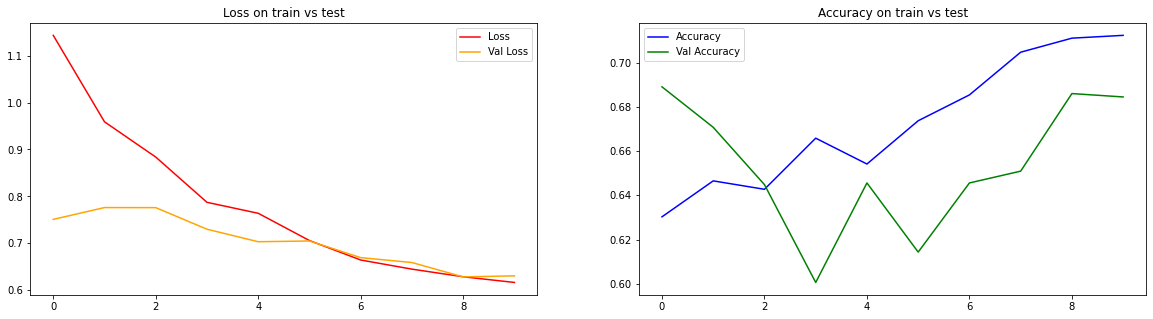

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=histry1.epoch, y=histry1.history['loss'], color='red', label='Loss')
sns.lineplot(x=histry1.epoch, y=histry1.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=histry1.epoch, y=histry1.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=histry1.epoch, y=histry1.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

### 6a. EfficientNet Results

In [ ]:
# Model evaluation on test dataset and getting the metrics
metrics1 = model.evaluate(testdata.test_generator, verbose=1)
print("Accuracy:", metrics1[1])
print("Precision:", metrics1[2])
print("Recall:", metrics1[3])

10/10 [==============================] - 10s 937ms/step - loss: 0.6942 - accuracy: 0.6202 - precision_1: 0.6202 - recall_1: 0.6202
Accuracy: 0.620192289352417
Precision: 0.620192289352417
Recall: 0.620192289352417


### 7. Quantitative Results

10/10 [==============================] - 12s 945ms/step
pred: (624, 2)
labels: {'NORMAL': 0, 'PNEUMONIA': 1}
['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMON

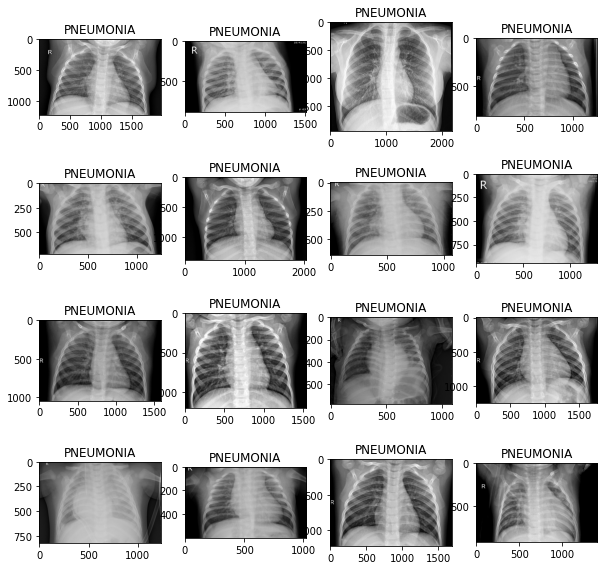

In [ ]:
# Qualitative results - visualization
# Getting predicitons
testdata.test_generator.reset()
pred=model.predict(testdata.test_generator,verbose=1)
print("pred:", pred.shape)
predicted_class_indices=np.argmax(pred,axis=1)
#print("pred class:", predicted_class_indices)
labels = (traindata.train_generator.class_indices)
print("labels:", labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)
filenames=testdata.test_generator.filenames

# Taking sample of 16 predictions
sample_f=random.sample(filenames, 16)
sample_p=random.sample(predictions, 16)

# Visualization of predictions
imgs, labels = [], []
for f, l in zip(sample_f, sample_p):
  imgs.append(cv2.imread(f))
  labels.append(l)
_, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### 8. Model 2  - ResNet model

In [ ]:
# Model definition - efficientnet from keras applications with imagenet weights for transfer learning
conv_base2 = resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(256,256,3))
model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model2.add(layers.Dropout(0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model2.add(layers.Dense(2, activation="softmax", name="fc_out"))
#conv_base2.trainable = False  # freezing the base model
model2.compile(optimizers.Adam(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training the model
histry2 = model2.fit(traindata.train_generator,
                    validation_data=traindata.valid_generator,
                    epochs=10
)

Epoch 1/10
62/62 [==============================] - 95s 2s/step - loss: 2.0230 - accuracy: 0.6181 - precision_2: 0.6181 - recall_2: 0.6181 - val_loss: 1.7916 - val_accuracy: 0.5061 - val_precision_2: 0.5061 - val_recall_2: 0.5061
Epoch 2/10
62/62 [==============================] - 93s 2s/step - loss: 1.8521 - accuracy: 0.6328 - precision_2: 0.6328 - recall_2: 0.6328 - val_loss: 1.7370 - val_accuracy: 0.4703 - val_precision_2: 0.4703 - val_recall_2: 0.4703
Epoch 3/10
62/62 [==============================] - 93s 1s/step - loss: 1.6894 - accuracy: 0.6285 - precision_2: 0.6285 - recall_2: 0.6285 - val_loss: 2.5816 - val_accuracy: 0.4253 - val_precision_2: 0.4253 - val_recall_2: 0.4253
Epoch 4/10
62/62 [==============================] - 92s 1s/step - loss: 1.6773 - accuracy: 0.6338 - precision_2: 0.6338 - recall_2: 0.6338 - val_loss: 1.3750 - val_accuracy: 0.6959 - val_precision_2: 0.6959 - val_recall_2: 0.6959
Epoch 5/10
62/62 [==============================] - 91s 1s/step - loss: 1.5886 -

### 9. Train vs Validation

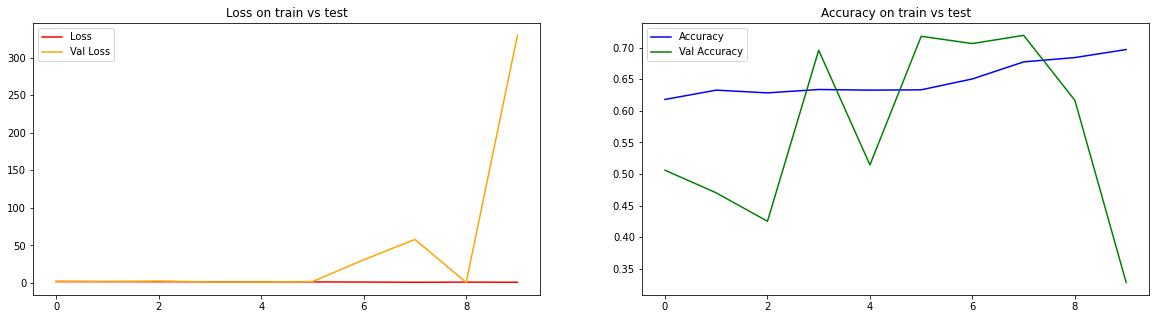

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=histry2.epoch, y=histry2.history['loss'], color='red', label='Loss')
sns.lineplot(x=histry2.epoch, y=histry2.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=histry2.epoch, y=histry2.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=histry2.epoch, y=histry2.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

### 9a. EfficientNet Results

In [ ]:
# Model evaluation on test dataset and getting the metrics
metrics2 = model2.evaluate(testdata.test_generator, verbose=1)
print("Accuracy:", metrics2[1])
print("Precision:", metrics2[2])
print("Recall:", metrics2[3])

10/10 [==============================] - 10s 955ms/step - loss: 253.0919 - accuracy: 0.4295 - precision_2: 0.4295 - recall_2: 0.4295
Accuracy: 0.4294871687889099
Precision: 0.4294871687889099
Recall: 0.4294871687889099


### 10. Resnet - Quantitative Results

10/10 [==============================] - 10s 949ms/step
pred: (624, 2)
labels: {'NORMAL': 0, 'PNEUMONIA': 1}


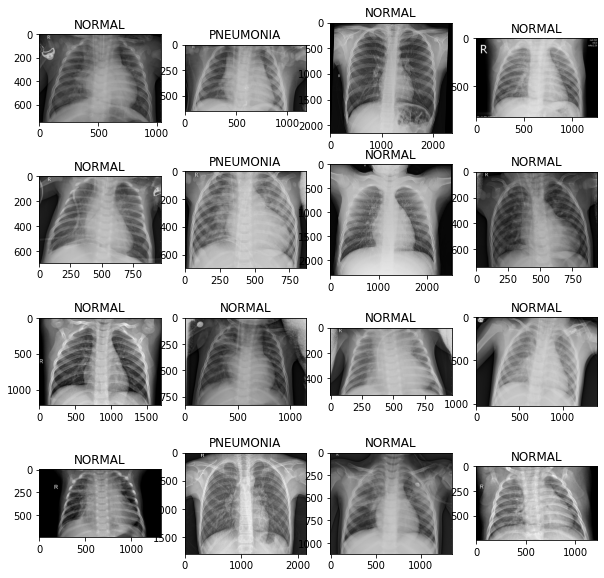

In [ ]:
# Qualitative results - visualization
testdata.test_generator.reset()
pred=model2.predict(testdata.test_generator,verbose=1)
print("pred:", pred.shape)
predicted_class_indices=np.argmax(pred,axis=1)
#print("pred class:", predicted_class_indices)
labels = (traindata.train_generator.class_indices)
print("labels:", labels)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
#print(predictions)
filenames=testdata.test_generator.filenames

sample_f=random.sample(filenames, 16)
sample_p=random.sample(predictions, 16)

# Visualization of predictions
imgs, labels = [], []
for f, l in zip(sample_f, sample_p):
  imgs.append(cv2.imread(f))
  labels.append(l)
_, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

## 11. Model Comparison

In [ ]:
print("Metrics for EfficientNet model:")
print("Accuracy:",metrics1[1], "Precision:", metrics1[2], "Recall:", metrics1[3])
print("Metrics for ResNet50 model:")
print("Accuracy:",metrics2[1], "Precision:", metrics2[2], "Recall:", metrics2[3])

Metrics for EfficientNet model:
Accuracy: 0.620192289352417 Precision: 0.620192289352417 Recall: 0.620192289352417
Metrics for ResNet50 model:
Accuracy: 0.4294871687889099 Precision: 0.4294871687889099 Recall: 0.4294871687889099


### 12. Saving Models
Note: These models are uploaded on Google Drive (link present on github README file)

In [ ]:
joblib.dump(model, 'pneumonia_efficientnetb3_clf.pkl')
joblib.dump(model2, 'pneumonia_resnet50_clf.pkl')

INFO:tensorflow:Assets written to: ram://765b971d-c4b5-48a9-a60a-a6f1461e70e1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://1a18befa-22a1-4001-aa1c-f3ecd88a3fa3/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


['pneumonia_resnet50_clf.pkl']